# Import libraries

In [ ]:
import torch

import os
import random
import pandas
import numpy
import math
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import imageio

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import style
import matplotlib.font_manager

# seed = 7777
# random.seed(seed) 
# torch.manual_seed(seed);

In [ ]:
# pair_no = 1
# BASE_PATH = "drive/MyDrive/"
# RESULT_PATH = "optimization_result/"+str(pair_no)+"_SplineFit/"
# FULL_PATH = BASE_PATH + RESULT_PATH

In [ ]:
# pairs = []
# file1 = open(BASE_PATH + 'dwpt_v5/pairs.txt', 'r')
# lines = file1.readlines()
# for line in lines:
#     pairs.append([int(i) for i in line.strip().split(',')])
# pair = pairs[pair_no]
# print(pair)

In [ ]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Saved MP (Magnetic Parameter) Model

In [ ]:
# 12 input -> 42 output
class MpModel(torch.nn.Module):
    def __init__(self):
        super(MpModel, self).__init__()

        self.linear1 = torch.nn.Linear(12, 100, bias=True)
        self.linear2 = torch.nn.Linear(100, 100, bias=True)
        self.linear3 = torch.nn.Linear(100, 42, bias=True)

    def forward(self, x):
        x = torch.atan(self.linear1(x))
        x = torch.atan(self.linear2(x))
        x = torch.atan(self.linear2(x))
        x = self.linear3(x)
        return x


mp_model = MpModel().to("cuda")
mp_model.load_state_dict(torch.load("saved_model_state.pt"))

for param in mp_model.parameters():
    param.requires_grad = False

# Create GP (Geometry Paramter) Generator

In [ ]:
class GpModel(torch.nn.Module):
    def __init__(self, input_length: int):
        super(GpModel, self).__init__()

        self.dense_layer1 = torch.nn.Linear(int(input_length), 128)
        self.dense_layer2 = torch.nn.Linear(128, 256)
        # self.dense_layer3 = torch.nn.Linear(256, 512)
        # self.dense_layer4 = torch.nn.Linear(512, 256)
        self.dense_layer5 = torch.nn.Linear(256, 128)
        self.dense_layer6 = torch.nn.Linear(128, int(input_length))
        
        self.batch_norm1 = torch.nn.LazyBatchNorm1d()
        self.batch_norm2 = torch.nn.LazyBatchNorm1d()
        self.batch_norm3 = torch.nn.LazyBatchNorm1d()
        self.batch_norm4 = torch.nn.LazyBatchNorm1d()
        self.batch_norm5 = torch.nn.LazyBatchNorm1d()

    def forward(self, x):
        x = self.batch_norm1(torch.atan(self.dense_layer1(x)))
        x = self.batch_norm2(torch.atan(self.dense_layer2(x)))
        # x = self.batch_norm3(torch.atan(self.dense_layer3(x)))
        # x = self.batch_norm4(torch.atan(self.dense_layer4(x)))
        x = self.batch_norm5(torch.atan(self.dense_layer5(x)))
        x = torch.sigmoid(self.dense_layer6(x))
        return x


gp_model = GpModel(10).to("cuda")
optimizer = torch.optim.Adam(gp_model.parameters(), lr=3e-4)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# System Constraints

In [ ]:
# x-direction of the primary winding (mm)
lpx_min, lpx_max = (50.0, 650.0)

# y-direction of the primary winding (mm)
lpy_min, lpy_max = (50.0, 2050.0)

# width of the primary winding (mm)
wp_min, wp_max = (25.0, 325.0)

# length of the edge of the primary core (mm)
a_min, a_max = (0.0, 200.0)

# pitch of the adjacent cores (mm)
p_min, p_max = (0.0, 200.0)

# length of the secondary winding (mm)
ls_min, ls_max = (50.0, 450.0)

# width of the secondary winding (mm)
ws_min, ws_max = (25.0, 225.0)

# input RMS current (A)
ip_min, ip_max = (50.0, 200.0)

# turn number of the primary side
np_min, np_max = (4.0, 10.0)

# turn number of the secondary side
ns_min, ns_max = (4.0, 10.0)

# switching frequency (kHz)
f = 85 * (10 ** 3)

# output power at the center (kW)
p_out = 50 * (10 ** 3)

# input DC voltage (V)
v_dc = 400

# output DC voltage (V)
v_bat = 400

# length of the edge of the secondary core
b = 50

# ???
w = 2 * numpy.pi * f  # [rad/s]

# ???
q_coil = 400

# Helper functions

In [ ]:
# Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
# Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.

@torch.jit.script
def linspace(start: torch.Tensor, stop: torch.Tensor, num: int):
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)

    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)

    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps * (stop - start)[None]

    return out

In [ ]:
# Generate a pytorch tensor full of random floats in the range [-1, +1] with the given shape

def generate_noise(shape):
    return torch.distributions.uniform.Uniform(-1, +1).sample(shape).cuda()

In [ ]:
def stack_parameters(*params):
    return torch.stack(params).transpose(0, 1)


# Scale an array to be between our specified [min, max] contraints
def scale(arr):
    scaler_min = torch.tensor(
        [a_min, lpx_min, lpy_min, ls_min, p_min, wp_min, ws_min, ip_min, np_min, ns_min],
        device="cuda",
    )
    scaler_max = torch.tensor(
        [a_max, lpx_max, lpy_max, ls_max, p_max, wp_max, ws_max, ip_max, np_max, ns_max],
        device="cuda",
    )

    return arr * (scaler_max - scaler_min) + scaler_min


def extract(arr):
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns = [
        numpy.squeeze(x) for x in numpy.hsplit(arr, 10)
    ]

    ys_min = (
        5 * wp +
        4 * a +
        3 * lpy +
        2 * p
    )

    ys_max = (lpy + wp)
    ys_max = ys_min + (ys_min - ys_max) / 2

    ys_min /= 2
    ys_max /= 2

    ys = linspace(ys_min, ys_max, num=5)

    np = torch.round(np)
    ns = torch.round(ns)

    # take all 15 tensors of shape (X) and convert to (15, X)
    return a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys


def scale_and_extract(arr):
    scaled_array = scale(arr)
    return extract(scaled_array)

In [ ]:
# Enclose in a function so we don't leak variables
def test_models():
    noise = generate_noise(shape=(256, 10))
    gp = gp_model(noise)
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)

    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns)

    mp = mp_model(gp_parameters)

    print(f"""
    GP Parameters Shape:    {gp_parameters.shape}
    Extra Parameters Shape: {extra_parameters.shape}
    MP Model Output Shape:  {mp.shape}
    """)
test_models()


    GP Parameters Shape:    torch.Size([256, 12])
    Extra Parameters Shape: torch.Size([256, 3])
    MP Model Output Shape:  torch.Size([256, 42])
    


In [ ]:
"""
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
"""


def pareto_frontier(x, y, max_x=False):
    if max_x:
        return _pareto_frontier(y, x)
    else:
        return _pareto_frontier(x, y)


def _pareto_frontier(x, y):
    # Combine inputs and sort them with smallest X values coming first
    sorted_xy = sorted(zip(x, y))
    p_front_x = torch.zeros(len(x), device="cuda")
    p_front_y = torch.zeros(len(y), device="cuda")
    
    # Loop through the sorted list
    #   Look for lower values of Y…
    #   and add them to the Pareto frontier
    min_y = sorted_xy[0][1]
    for index in range(len(sorted_xy)):
        x, y = sorted_xy[index]
        if y < min_y:
            min_y = y
            p_front_x[index] = x
            p_front_y[index] = y
            
    p_front_x = p_front_x[p_front_x.nonzero()]
    p_front_y = p_front_y[p_front_y.nonzero()]

    return p_front_x, p_front_y

In [ ]:
#testing for creating total pareto f

def oldgraph_pareto_frontier(Xs, Ys, maxX = False, maxY = False):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
            p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

In [ ]:
def findSpline(x, y, smoothing_factor = 2):
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(smoothing_factor)
    return spl

In [ ]:
def pair_loss_calc(x, y, x_numpy, y_numpy, pareto_x_numpy, pareto_y_numpy, pareto_x_forx_numpy, pareto_y_forx_numpy):
    if len(pareto_y_numpy) > 3:
        # f = interp1d(pareto_bstray_numpy[:,0], pareto_kdiff_numpy[:,0])
        # f2 = interp1d(pareto_bstray_numpy[:,0], pareto_kdiff_numpy[:,0], kind = 'cubic')
        # plt.plot(pareto_bstray_numpy[:,0], f2(pareto_bstray_numpy[:,0]), '--', pareto_bstray_numpy, pareto_kdiff_numpy, 'o')


        spl_y = findSpline(pareto_x_numpy[:,0], pareto_y_numpy[:,0])
        y_calc = torch.as_tensor(spl_y(x_numpy)).cuda()
        # plt.plot(pareto_bstray_numpy[:,0], spl_y(pareto_bstray_numpy[:,0]), '--', pareto_bstray_fory_numpy, pareto_kdiff_fory_numpy, 'o')
        # plt.show()
        y_loss = y - y_calc
        y_loss_relu = torch.nn.functional.relu(y_loss)


        spl_x = findSpline(pareto_y_forx_numpy[:,0], pareto_x_forx_numpy[:,0])
        # plt.plot(spl_x(pareto_kdiff_fory_numpy[:,0]), pareto_kdiff_fory_numpy[:,0], '--', pareto_bstray_fory_numpy, pareto_kdiff_fory_numpy,  'o')
        # plt.show()


        x_calc = torch.as_tensor(spl_x(y_numpy)).cuda()
        x_loss = x - x_calc
        x_loss_relu = torch.nn.functional.relu(x_loss)
       

    if len(pareto_x_numpy) > 3 and len(pareto_y_numpy) > 3:
        combined_loss = torch.sum(y_loss_relu * x_loss_relu)
    else: 
        combined_loss = torch.zeros(1, requires_grad=True, device = "cuda")
        # print('No new pareto points found, used zero grad')
    
    
    return combined_loss

In [ ]:
def compute_pairloss_and_pareto(x, y):
    
    pareto_x, pareto_y = pareto_frontier(x, y)
    pareto_y_forx, pareto_x_forx = pareto_frontier(y, x)
    
    pareto_x_numpy = pareto_x.cpu().data.numpy()
    pareto_y_numpy = pareto_y.cpu().data.numpy()
    
    pareto_x_forx_numpy = pareto_x_forx.cpu().data.numpy()
    pareto_y_forx_numpy = pareto_y_forx.cpu().data.numpy()
    
    x_numpy = x.cpu().data.numpy()
    y_numpy = y.cpu().data.numpy()
    
    x_y_loss = pair_loss_calc(x, y, x_numpy, y_numpy, pareto_x_numpy, pareto_y_numpy, pareto_x_forx_numpy, pareto_y_forx_numpy)
    
    return x_y_loss, pareto_x, pareto_y, x_numpy, y_numpy, pareto_x_numpy, pareto_y_numpy, pareto_x_forx_numpy, pareto_y_forx_numpy

In [ ]:
def pave_tomax(pavemin, pave_max_value=10000):
    pave_max = torch.sub(pave_max_value, pavemin)
    return pave_max

# Load DWPT data

In [ ]:
def load_dwpt():
    folder_name = "./dwpt_v5"
    file_names = [
        "DWPT_v5_N10",
        "DWPT_v5_N100",
        "DWPT_v5_N200",
        "DWPT_v5_N300",
        "DWPT_v5_N400",
    ]

    df = pandas.DataFrame()

    for file_name in file_names:
        new_df = pandas.read_csv(f"{folder_name}/{file_name}_after.csv", index_col=0)
        df = pandas.concat([df, new_df])

    return df

df = load_dwpt()
df_gp = df.loc[:, :"ys4[mm]"]
df_mp = df.loc[:, "k0mm_ys0":]

print(df_gp.shape)
print(df_mp.shape)

(1010, 12)
(1010, 42)


# Define Loss Functions

In [ ]:
import math
f = 85*10**3 #[Hz]
w =2*math.pi*f #[rad/s]
Pout= 50000 #W
Vdc = 400 #800 # V
Vbat = 400 #V
QCoil = 400
b = 50

In [ ]:
def kdiff_loss(k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters

    kdiff = abs(k_0_0 - k_1_0)
    kdiff = kdiff / torch.max(abs(k_0_0), abs(k_1_0))

    return kdiff

def calculate_Is(l_parameters, k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters

    a6 = lp_0_0 * np ** 2
    a11 = ls_0_0 * ns ** 2
  # Paper formula
    n1 = (torch.pi * w * a6 * ip) / (2*numpy.sqrt(2) * v_dc)
    t1 = (torch.pi ** 2 * w * p_out * torch.sqrt(a6 * a11))
    t2 = 8 * k_0_0 * n1 * v_dc * v_bat
    n2 = t1 / t2
    Is = (4 * v_bat * n2) / (torch.pi * w * a11)

    return Is
  
def bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters):
    # Unpack parameters
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters

    Is = calculate_Is(l_parameters,k_parameters)

    bx_100 = (
        (bx_p_1_00 * ip * np + bx_s_1_00 * Is * ns) ** 2 +
        (bx_p_1_90 * ip * np + bx_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    by_100 = (
        (by_p_1_00 * ip * np + by_s_1_00 * Is * ns) ** 2 +
        (by_p_1_90 * ip * np + by_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    bz_100 = (
        (bz_p_1_00 * ip * np + bz_s_1_00 * Is * ns) ** 2 +
        (bz_p_1_90 * ip * np + bz_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    b_100 = (bx_100**2 + by_100**2 + bz_100**2) ** 0.5

    bstray = b_100

    return bstray

In [ ]:
# import seaborn as sns
# plt.style.use(['science','no-latex'])

# fig_width = 8 #cm # Setting for Conference paper 
# fig_height = 3 #cm
# font_size = 7 # pt
# fig_update = True
# marker_size = 5
# x_tick_pad = 2
# y_tick_pad = 2
# x_label_pad = 0.5
# y_label_pad = 1

# def plot_(**kwargs):
#     import numpy as np
#     plt.close('all')
#     kdiff = kwargs["kdiff"] * 100
#     pave = kwargs["pave"] 
#     coilloss = kwargs["coilloss"]
#     bstray = kwargs["bstray"]
#     vpricore = kwargs["vpricore"]
#     vsecwind = kwargs["vsecwind"]
#     n_inv = kwargs["n_inv"]
#     vseccore = kwargs["vseccore"]
#     epoch = kwargs["epoch"]

#     marker_size = 60


#     font = {'family' : 'normal',
#           'weight' : 'bold',
#           'size'   : 12}

#     plt.rc('font', **font)

#     #plt.style.use(['science','no-latex'])

#     fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4)

#     #fig.subplots_adjust(hspace=10)

#     fig.set_size_inches(16,4)
#     #ax1.set_aspect('equal')
#     #fig.tight_layout(pad=6)
#     fig.tight_layout(pad = 2)

#     xlim = 1 #Number of Inverter [1/m]
#     ylim = 2000 #Coil loss [W] 
#     ax1.set_xlabel(r"$Number\ of\ inverter\ [1/m]$", labelpad = x_label_pad)              # not shown
#     ax1.set_ylabel(r'$Coil loss [W]$', labelpad = y_label_pad) # not shown
#     x1 = np.arange(0, xlim + 0.1,0.1)
#     y1 = 0
#     y2 = ylim
#     plt_ax1 = ax1.scatter(n_inv, coilloss, rasterized=True)
#     #fig.colorbar(mappable = plt_ax1 , ax = ax1, label=r"$B_{\rm stray}~[\rm \mu T]$")
#     ax1.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
#     ax1.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
#     ax1.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
#     ax1.axis([0,2, 0,5000])
#     ax1.tick_params(axis='x', pad=15)
#     # ax1.set_aspect('equal')



#     xlim = 40
#     ylim = 15
#     ax2.set_xlabel(r"$B_{\rm stray}~[\rm \mu T]$", labelpad = x_label_pad)              # not shown
#     ax2.set_ylabel(r'$Coupling [\%]$', labelpad = y_label_pad) # not shown

#     x1 = np.arange(0, xlim + 0.1, 0.1)
#     y1 = 0
#     y2 = ylim

#     plt_ax2 = ax2.scatter(bstray, kdiff,rasterized=True)
#     #fig.colorbar(mappable = plt_ax2 , ax = ax2, label=r"$V_{PriCore}$")
#     ax2.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
#     ax2.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
#     ax2.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
#     ax2.axis([0, 100, 0, 50])
#     ax2.tick_params(axis='x', pad=15)

#     # ax2.set_aspect('equal')

#     xlim = 3500
#     ylim = 30

#     ax3.set_xlabel(r"$V_{SecCore}$", labelpad = x_label_pad)              # not shown
#     ax3.set_ylabel(r'$P_{ave} [KW/M]$', labelpad = y_label_pad) # not shown

#     x1 = np.arange(0, xlim + 0.1, 0.1)
#     y1 = ylim
#     y2 = ylim*10

#     plt_ax3 = ax3.scatter(vseccore, pave, rasterized=True)
#     #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
#     ax3.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
#     ax3.plot([xlim, xlim], [ylim, ylim*10], 'r--', lw=0.5)  
#     ax3.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
#     ax3.axis([0, 5000, 0, 200])
#     ax3.tick_params(axis='x', pad=15)
#     # ax3.set_aspect('equal')


#     xlim = 3500
#     ylim = 6000

#     ax4.set_xlabel(r"$V_{SecCore}$", labelpad = x_label_pad)              # not shown
#     ax4.set_ylabel(r'$V_{PriCore} $', labelpad = y_label_pad) # not shown

#     x1 = np.arange(0, xlim + 0.1, 0.1)
#     y1 = 0
#     y2 = ylim

#     ax4.scatter(vseccore, vpricore, s=marker_size, cmap ='viridis',rasterized=True)
#     #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
#     ax4.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
#     ax4.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
#     ax4.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
#     ax4.axis([0, 5000, 0, 7000])
#     ax4.tick_params(axis='x', pad=15)

#     plt.suptitle("Epoch "+str(epoch), y = 1.05, c='r')
#     # plt.savefig("images/"+ str(epoch) +".png")
#     plt.show()
#     plt.clf()
    
  

In [ ]:
import matplotlib
import seaborn as sns

fig_width = 8 #cm # Setting for Conference paper 
fig_height = 3 #cm
font_size = 7 # pt
fig_update = True
marker_size = 5
x_tick_pad = 2
y_tick_pad = 2
x_label_pad = 0.5
y_label_pad = 1

plt.style.use(['science','no-latex'])
def plot_(**kwargs):
    import numpy as np
    plt.close('all')
    kdiff = kwargs["kdiff"] * 100
    pave = kwargs["pave"] 
    coilloss = kwargs["coilloss"]
    bstray = kwargs["bstray"]
    vpricore = kwargs["vpricore"]
    vsecwind = kwargs["vsecwind"]
    n_inv = kwargs["n_inv"]
    vseccore = kwargs["vseccore"]
    epoch = kwargs["epoch"]

    marker_size = 1


    font = {'family' : 'normal',
          'weight' : 'bold',
          'size'   : 12}

    matplotlib.rc('font', **font)

    #plt.style.use(['science','no-latex'])

    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4)

    #fig.subplots_adjust(hspace=10)

    fig.set_size_inches(16,4)
    #ax1.set_aspect('equal')
    #fig.tight_layout(pad=6)
    fig.tight_layout(pad = 2)

    xlim = 1 #Number of Inverter [1/m]
    ylim = 2000 #Coil loss [W] 
    ax1.set_xlabel(r"$Number\ of\ inverter\ [1/m]$", labelpad = x_label_pad)              # not shown
    ax1.set_ylabel(r'$Coil loss [W]$', labelpad = y_label_pad) # not shown
    x1 = np.arange(0, xlim + 0.1,0.1)
    y1 = 0
    y2 = ylim
    plt_ax1 = ax1.scatter(n_inv, coilloss, s=marker_size, rasterized=True)
    #fig.colorbar(mappable = plt_ax1 , ax = ax1, label=r"$B_{\rm stray}~[\rm \mu T]$")
    ax1.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
    ax1.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
    ax1.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
    ax1.axis([0,2, 0,5000])
    ax1.tick_params(axis='x', pad=15)
    # ax1.set_aspect('equal')



    xlim = 45
    ylim = 15
    ax2.set_xlabel(r"$B_{\rm stray}~[\rm \mu T]$", labelpad = x_label_pad)              # not shown
    ax2.set_ylabel(r'$Coupling [\%]$', labelpad = y_label_pad) # not shown

    x1 = np.arange(0, xlim + 0.1, 0.1)
    y1 = 0
    y2 = ylim

    plt_ax2 = ax2.scatter(bstray, kdiff,s=marker_size,rasterized=True)
    #fig.colorbar(mappable = plt_ax2 , ax = ax2, label=r"$V_{PriCore}$")
    ax2.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
    ax2.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
    ax2.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
    ax2.axis([0, 100, 0, 40])
    ax2.tick_params(axis='x', pad=15)

    # ax2.set_aspect('equal')

    xlim = 3500
    ylim = 30

    ax3.set_xlabel(r"$V_{SecCore}$", labelpad = x_label_pad)              # not shown
    ax3.set_ylabel(r'$P_{ave} [KW/M]$', labelpad = y_label_pad) # not shown

    x1 = np.arange(0, xlim + 0.1, 0.1)
    y1 = ylim
    y2 = ylim*10

    ax3.scatter(vseccore, pave,s=marker_size, rasterized=True)
    #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
    ax3.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
    ax3.plot([xlim, xlim], [ylim, ylim*10], 'r--', lw=0.5)  
    ax3.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
    ax3.axis([0, 5000, 0, 80])
    ax3.tick_params(axis='x', pad=15)
    # ax3.set_aspect('equal')


    xlim = 750
    ylim = 6000

    ax4.set_xlabel(r"$V_{SecWind}$", labelpad = x_label_pad)              # not shown
    ax4.set_ylabel(r'$V_{PriCore} $', labelpad = y_label_pad) # not shown

    x1 = np.arange(0, xlim + 0.1, 0.1)
    y1 = 0
    y2 = ylim

    ax4.scatter(vsecwind, vpricore, s=marker_size, rasterized=True)
    #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
    ax4.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
    ax4.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
    ax4.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
    ax4.axis([0, 2000, 0, 8000])
    ax4.tick_params(axis='x', pad=15)

    plt.suptitle("Epoch "+str(epoch).zfill(5) + "\nFound "+ str(accepted_solution_so_far)+ " solutions out of 1000 input \nMean Loss", y = 1.15, c='r')
    plt.savefig("MeanLoss/" + str(epoch).zfill(5)+".png")
    plt.show()
    plt.clf()

In [ ]:
def generate_solution_plot(**kwargs):
  kdiff = kwargs["kdiff"] * 100
  pave = kwargs["pave"] /1000
  coilloss = kwargs["coilloss"]
  bstray = kwargs["bstray"]
  vpricore = kwargs["vpricore"]
  vsecwind = kwargs["vsecwind"]
  n_inv = kwargs["n_inv"]
  vseccore = kwargs["vseccore"]

  accepted_n_inv_ = [] 
  accepted_coilloss = [] 
  accepted_bstray = []
  accepted_kdiff = []
  accepted_v_sec_core = []
  accpeted_pave = []
  accepted_v_sec_wind = []
  accpeted_v_pri_core = []

  for i in range(len(kdiff)):
    if n_inv[i] < 1 and coilloss[i] < 2000 and bstray[i] < 50 and \
    kdiff[i] < 40 and vseccore[i] < 1500 and pave[i] > 30 and vsecwind[i] < 750 and vpricore[i] < 6000:
      accepted_n_inv_.append(n_inv[i])
      accepted_coilloss.append(coilloss[i])
      accepted_bstray.append(bstray[i])
      accepted_kdiff.append(kdiff[i])
      accepted_v_sec_core.append(vseccore[i])
      accpeted_pave.append(pave[i])
      accepted_v_sec_wind.append(vsecwind[i])
      accpeted_v_pri_core.append(vpricore[i])


  import matplotlib
  import seaborn as sns
  import numpy as np

  plt.subplots_adjust(left=.1,
                      bottom=0.1,
                      right=0.9,
                      top=2,
                      wspace=2,
                      hspace=0.4)

  font = {'family' : 'normal',
          'weight' : 'bold',
          'size'   : 15}

  matplotlib.rc('font', **font)
  color_list = sns.color_palette("Paired", n_colors=len(accpeted_v_pri_core))

  plt.style.use(['science','no-latex'])
  #matplotlib.rcParams.update({'font.size': font_size, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


  #fig1=plt.figure(figsize=(cm2inch(fig_width/2),cm2inch(fig_height)/1.2), dpi=400)

  marker_size = 50

  #plt.style.use(['science','no-latex'])

  fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4)

  #fig.subplots_adjust(hspace=10)

  fig.set_size_inches(16,4)
  #ax1.set_aspect('equal')
  #fig.tight_layout(pad=6)
  fig.tight_layout(pad = 2)

  xlim = 1 #Number of Inverter [1/m]
  ylim = 2000 #Coil loss [W] 
  ax1.set_xlabel(r"$Number\ of\ inverter\ [1/m]$", labelpad = x_label_pad)              # not shown
  ax1.set_ylabel(r'$Coil loss [W]$', labelpad = y_label_pad) # not shown
  x1 = np.arange(0, xlim + 0.1,0.1)
  y1 = 0
  y2 = ylim
  plt_ax1 = ax1.scatter(accepted_n_inv_, accepted_coilloss, s=marker_size, c= color_list, rasterized=True)
  #fig.colorbar(mappable = plt_ax1 , ax = ax1, label=r"$B_{\rm stray}~[\rm \mu T]$")
  ax1.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
  ax1.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
  ax1.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
  ax1.axis([0,2, 0,5000])
  ax1.tick_params(axis='x', pad=15)
  # ax1.set_aspect('equal')



  xlim = 100
  ylim = 40
  ax2.set_xlabel(r"$B_{\rm stray}~[\rm \mu T]$", labelpad = x_label_pad)              # not shown
  ax2.set_ylabel(r'$Coupling [\%]$', labelpad = y_label_pad) # not shown

  x1 = np.arange(0, xlim + 0.1, 0.1)
  y1 = 0
  y2 = ylim

  plt_ax2 = ax2.scatter(accepted_bstray, accepted_kdiff,s=marker_size, c= color_list, rasterized=True)
  #fig.colorbar(mappable = plt_ax2 , ax = ax2, label=r"$V_{PriCore}$")
  ax2.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
  ax2.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
  ax2.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
  ax2.axis([0, 200, 0, 60])
  ax2.tick_params(axis='x', pad=15)

  # ax2.set_aspect('equal')

  xlim = 3500
  ylim = 30

  ax3.set_xlabel(r"$V_{SecCore}$", labelpad = x_label_pad)              # not shown
  ax3.set_ylabel(r'$P_{ave} [KW/M]$', labelpad = y_label_pad) # not shown

  x1 = np.arange(0, xlim + 0.1, 0.1)
  y1 = ylim
  y2 = ylim*10

  ax3.scatter(accepted_v_sec_core, accpeted_pave,s=marker_size, c= color_list, rasterized=True)
  #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
  ax3.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
  ax3.plot([xlim, xlim], [ylim, ylim*10], 'r--', lw=0.5)  
  ax3.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
  ax3.axis([0, 5000, 0, 60])
  ax3.tick_params(axis='x', pad=15)
  # ax3.set_aspect('equal')


  xlim = 750
  ylim = 6000

  ax4.set_xlabel(r"$V_{SecWind}$", labelpad = x_label_pad)              # not shown
  ax4.set_ylabel(r'$V_{PriCore} $', labelpad = y_label_pad) # not shown

  x1 = np.arange(0, xlim + 0.1, 0.1)
  y1 = 0
  y2 = ylim

  ax4.scatter(accepted_v_sec_wind, accpeted_v_pri_core, s=marker_size, c= color_list, rasterized=True)
  #fig.colorbar(mappable = plt_ax3 , ax = ax3, label=r"$V_{SecWind}$")
  ax4.fill_between(x1, y1, y2 ,facecolor='r',alpha=0.3)
  ax4.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)  
  ax4.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5) 
  ax4.axis([0, 2000, 0, 8000])
  ax4.tick_params(axis='x', pad=15)

  plt.suptitle("Epoch " +str(epoch).zfill(5) + "\nFound "+ str(len(accepted_bstray))+ " solutions out of 1000 input", y = 1.10)
  plt.savefig(FULL_PATH + "Solutions/"+str(epoch).zfill(5) + ".png")
  # "Epoch "+str(epoch).zfill(5) + "\nFound "+ str(len(accepted_bstray))+ " solutions out of 1000 input"
  plt.clf()

In [ ]:
def accepted_solution(**kwargs):

    kdiff = kwargs["kdiff"] * 100
    pave = kwargs["pave"]
    coilloss = kwargs["coilloss"]
    bstray = kwargs["bstray"]
    vpricore = kwargs["vpricore"]
    vsecwind = kwargs["vsecwind"]
    n_inv = kwargs["n_inv"]
    vseccore = kwargs["vseccore"]

    count = 0
    for i in range(len(kdiff)):
        if n_inv[i] < 1 and coilloss[i] < 2000 and bstray[i] < 45 and \
        kdiff[i] < 15 and vseccore[i] < 1500 and pave[i] > 30:
            count += 1

    return count

In [ ]:
def number_of_inverters(gp_parameters):
    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.clone().transpose(0,1)
    
    number_of_inverters = 1/(lpy+2*wp+2*a+p)*10**3

    return number_of_inverters

In [ ]:
def core_losses(extra_parameters, gp_parameters):
    (
        ip, np, ns
    ) = extra_parameters

    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.transpose(0,1)
    
    V_PriCore = ((lpy +2*wp+2*a)*(lpx+2*wp+2*a)*5)/(10**3) # cm3
    V_SecCore = (((ls+2*ws+2*b)**2)*5)/(10**3)
    V_PriWind = (2*(lpx+wp)+2*(lpy+wp))*6.6*6.6/(10**3)*np
    V_SecWind = 4*(ls+ws)*6.6*6.6/(10**3)*ns
    
    V_PriCore_ave = V_PriCore/(lpy+2*wp+2*a+p)*10**3
    # V_PriWind_ave = V_PriWind/(lpy+2*wp+2*a+p)*10**3

    return V_PriCore, V_SecCore, V_PriWind, V_SecWind, V_PriCore_ave

In [ ]:
def calculate_coilloss_pave(k_parameters, l_parameters, b_parameters, extra_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters


    a6 = lp_0_0 * np**2  # LP0MM_YSO
    a7 = lp_0_1 * np**2  # LP0MM_YS1
    a8 = lp_0_2 * np**2  # LP0MM_YS2
    a9 = lp_0_3 * np**2  # LP0MM_YS3
    a10 = lp_0_4 * np**2 # LP0MM_YS4

    a11 = ls_0_0 * ns**2 # LS0MM_YSO
    a12 = ls_0_1 * ns**2 # LS0MM_YS1
    a13 = ls_0_2 * ns**2 # LS0MM_YS2
    a14 = ls_0_3 * ns**2 # LS0MM_YS3
    a15 = ls_0_4 * ns**2 # LS0MM_YS4

    Is = calculate_Is(l_parameters,k_parameters)
  
    loss = (w*a6*10**(-9)*ip**2/QCoil + w*a11*10**(-9)*Is**2/QCoil) 

    p0 = w*k_0_0*(a6 * a11)**0.5*ip*Is
    p1 = w*k_0_1*(a7 * a12)**0.5*ip*Is
    p2 = w*k_0_2*(a8 * a13)**0.5*ip*Is
    p3 = w*k_0_3*(a9 * a14)**0.5*ip*Is
    p4 = 2*w*k_0_4*(a10 * a15)**0.5*ip*Is
    pave = (p0+(2*p1)+(2*p2)+(2*p3)+ p4)/8
    pave_kW = pave / 1000

    return loss,pave_kW

# Neural Network Training Loop

Accepted Soluntions :  9


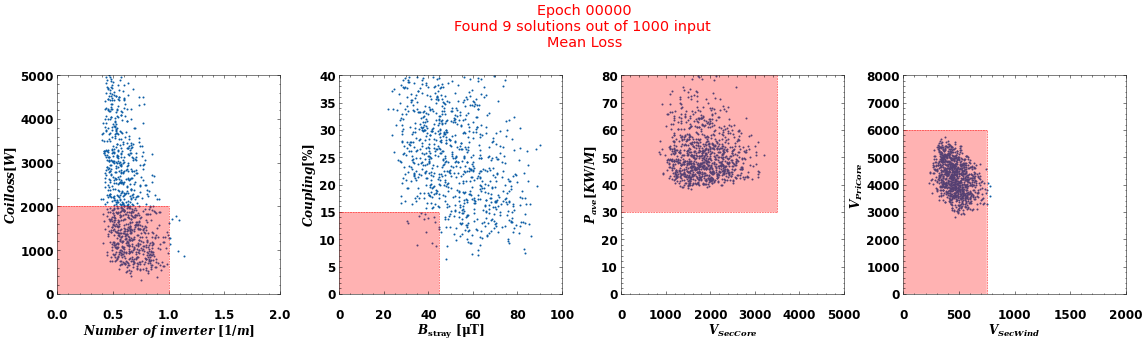

Accepted Soluntions :  34
Accepted Soluntions :  326
Accepted Soluntions :  878
Accepted Soluntions :  987
Accepted Soluntions :  999
Accepted Soluntions :  1000
Accepted Soluntions :  999
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000


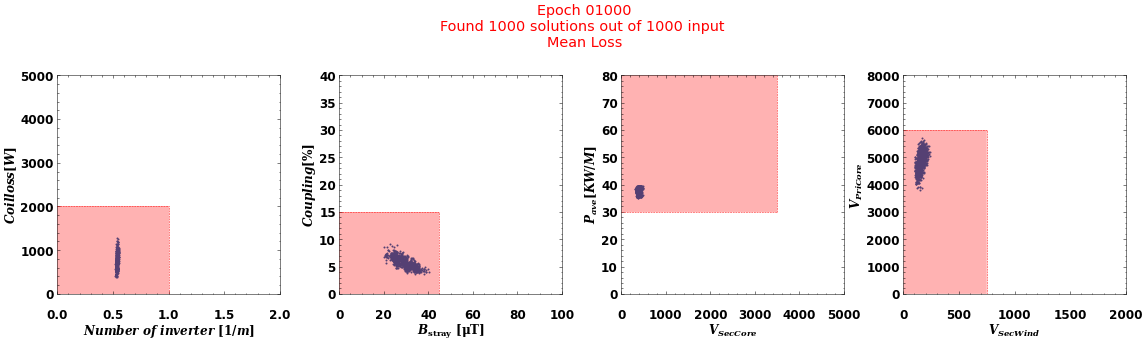

Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000


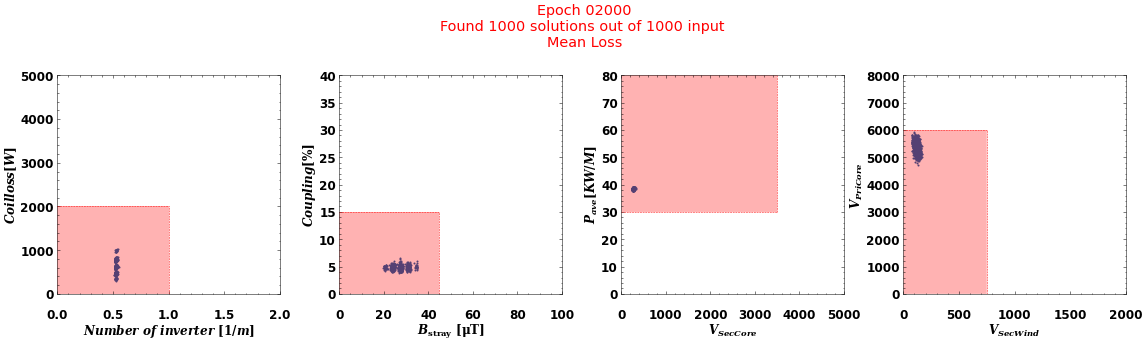

Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000


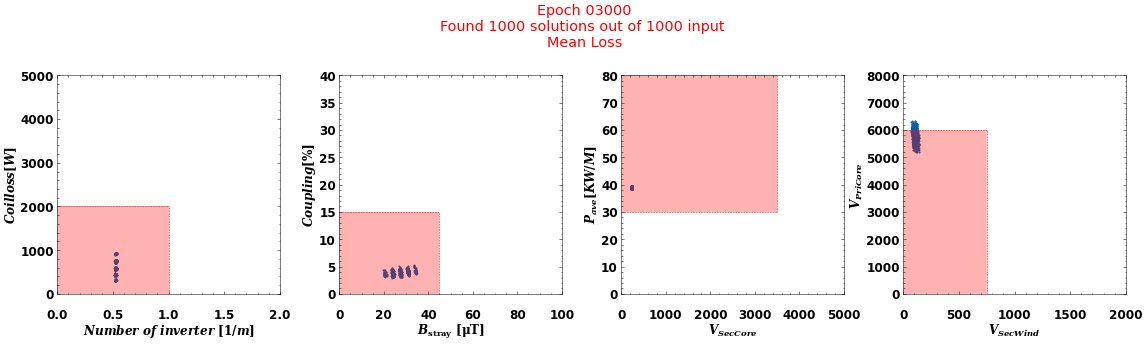

Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000


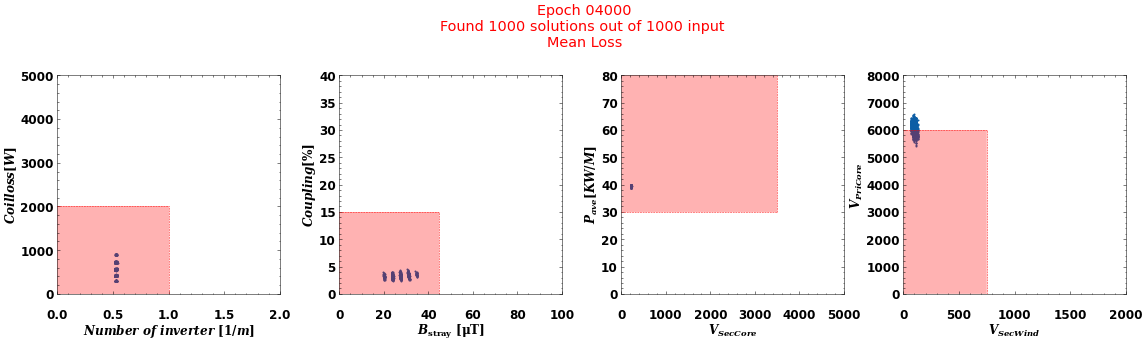

Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000
Accepted Soluntions :  1000


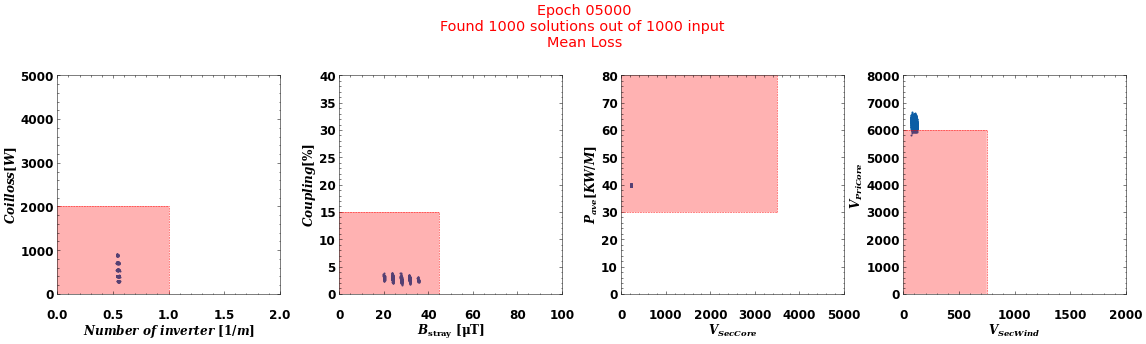

<Figure size 252x189 with 0 Axes>

In [ ]:
pareto_bstray_points = []
pareto_kdiff_points = []
pareto_numinv_points = []
pareto_coilloss_points = []
pareto_V_SecCore_points = []
pareto_pave_post_points = []

accepted_solutions = []
max_solution = -float('inf')

kdiffs = []
bstrays = []
numinvs = []
coillosses = []
combined_losses = []

#testing for graphs
kdiff_designs = []
bstray_designs = []
numinv_designs = []
coilloss_designs = []
V_SecCore_designs = []
pave_designs = []

pareto_bstray_points2 = []
pareto_kdiff_points2 = []

x_calc_numpy =[]
y_calc_numpy=[]
cumulative_solutions = [0]
i = 1
#training parameters
n_epochs = 5001
n_noise = 1000

for epoch in range(n_epochs):
    
    # Clear old gradients in the GP model
    for param in gp_model.parameters():
        param.grad = None

    # Create GP parameters from noise
    noise = generate_noise(shape=(n_noise, 10))
    gp = gp_model(noise)

    # Unpack and filter GP parameters
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

    V_PriCore, V_SecCore, V_PriWind,V_SecWind, V_PriCore_ave = core_losses(extra_parameters,gp_parameters)
    numinv = number_of_inverters(gp_parameters)
    
    # Scale GP parameters - why?
    min_x = torch.min(gp_parameters)
    max_x = torch.max(gp_parameters)
    gp_parameters = (gp_parameters - min_x) / (max_x - min_x)
  
    # Push GP parameters through MP model
    mp_parameters = mp_model(gp_parameters)

    # Scale MP parameters
    y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
    min_y = torch.min(y, 1).values
    max_y = torch.max(y, 1).values
    mp_parameters = mp_parameters * (max_y - min_y) + min_y

    k_parameters = mp_parameters.transpose(0, 1)[0:6]
    l_parameters = mp_parameters.transpose(0, 1)[6:18]
    b_parameters = mp_parameters.transpose(0, 1)[18:]

    # Calculate losses
    kdiff = kdiff_loss(k_parameters)
    bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
    # coilloss,pave = coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters)
    # print(pave)
    coilloss,pave = calculate_coilloss_pave(k_parameters, l_parameters, b_parameters, extra_parameters)
    
    #pmax - pave_kW, to get tensor to minimize, pavemin is tensor to minimize
    pavemin = torch.sub(10000, pave)

    # # Call pairwise pareto and loss
    # bstray_kdiff_loss, pareto_bstray, pareto_kdiff, bstray_numpy, kdiff_numpy, pareto_bstray_numpy, pareto_kdiff_numpy, pareto_bstray_forx_numpy, pareto_kdiff_forx_numpy = compute_pairloss_and_pareto(bstray, kdiff)
    # numinv_coilloss_loss, pareto_numinv, pareto_coilloss, numinv_numpy, coilloss_numpy, pareto_numinv_numpy, pareto_coilloss_numpy, pareto_numinv_forx_numpy, pareto_coilloss_forx_numpy = compute_pairloss_and_pareto(numinv, coilloss)
    # V_SecCore_pavemin_loss, pareto_V_SecCore, pareto_pavemin, V_SecCore_numpy, pavemin_numpy, pareto_V_SecCore_numpy, pareto_pavemin_numpy, pareto_V_SecCore_forx_numpy, pareto_pavemin_forx_numpy = compute_pairloss_and_pareto(V_SecCore, pavemin)
    # V_PriCore_V_SecWind_loss, pareto_V_PriCore, pareto_V_SecWind, V_PriCore_numpy, V_SecWind_numpy, pareto_V_PriCore_numpy, pareto_V_SecWind_numpy, pareto_V_PriCore_forx_numpy, pareto_V_SecWind_forx_numpy = compute_pairloss_and_pareto(V_PriCore, V_SecWind)
    # #get pave points for plotting
    # pareto_pave_post = pave_tomax(pareto_pavemin)
    
    if epoch%100 == 0:
        kwargs = {}

        kwargs["kdiff"] = kdiff.clone().detach().cpu().numpy()
        kwargs["pave"] = pave.clone().detach().cpu().numpy()
        kwargs["coilloss"] = coilloss.clone().detach().cpu().numpy()
        kwargs["bstray"] = bstray.clone().detach().cpu().numpy()
        kwargs["vpricore"] = V_PriCore_ave.clone().detach().cpu().numpy()
        kwargs["vsecwind"] = V_SecWind.clone().detach().cpu().numpy()
        kwargs["n_inv"] = numinv.clone().detach().cpu().numpy()
        kwargs["vseccore"] = V_SecCore.clone().detach().cpu().numpy()
        kwargs["epoch"] = epoch

        accepted_solution_so_far = accepted_solution(**kwargs)

    
        accepted_solutions.append(accepted_solution_so_far)
        print("Accepted Soluntions : ", accepted_solution_so_far)
        cumulative_solutions.append(cumulative_solutions[i - 1] + accepted_solution_so_far)
        i+=1
        generate_solution_plot(**kwargs)
        
        if max_solution < accepted_solution_so_far:
            torch.save(gp_model.state_dict(), f"./models/gp_model_{epoch:06}.pt")
            max_solution = accepted_solution_so_far
        
        if epoch%1000 == 0:
            plot_(**kwargs)
    
    #Spline Fit Loss
    # combined_loss = (bstray_kdiff_loss + numinv_coilloss_loss + V_SecCore_pavemin_loss)
    
    #Spline Fit Loss with V_PriCore and V_SecWind
    # combined_loss = (bstray_kdiff_loss + numinv_coilloss_loss + V_SecCore_pavemin_loss + V_PriCore_V_SecWind_loss)
    
    # ParetoPointMeanLoss
    # combined_loss = (torch.mean(pareto_bstray) + torch.mean(pareto_kdiff) + torch.mean(pareto_numinv) + torch.mean(pareto_coilloss) + torch.mean(pareto_V_SecCore) + torch.mean(pareto_pavemin))
     
    # ParetoPointMedianLoss
    # combined_loss = (torch.median(pareto_bstray) + torch.median(pareto_kdiff) + torch.median(pareto_numinv) + torch.median(pareto_coilloss) + torch.median(pareto_V_SecCore) + torch.median(pareto_pavemin))
    
    #SimpleMeanLoss
    combined_loss = (torch.mean(bstray) * torch.mean(kdiff) * torch.mean(numinv) * torch.mean(coilloss) * torch.mean(V_SecCore) * torch.mean(pavemin))

    # Push loss through the optimizer and update the GP model
    try:
        combined_loss.backward(retain_graph=True)
        optimizer.step()
    except Exception as e:
        print(f"Error on epoch {epoch} regarding", e)
        break

    
    #if epoch % 50 == 0:
        
#         # plt.plot(pareto_bstray_numpy[:,0], spl_y(pareto_bstray_numpy[:,0]), '--', bstray_numpy, kdiff_numpy, 'o')
#         plt.plot(pareto_bstray_numpy, pareto_kdiff_numpy)
#         plt.plot(bstray_numpy, kdiff_numpy, 'o')
#         # plt.plot(x_calc.cpu().data.numpy(), kdiff_numpy, 'o')
#         plt.xlim([0,100])
#         plt.ylim([0,0.5])
#         plt.show()
        
#         plt.plot(pareto_numinv_numpy, pareto_coilloss_numpy)
#         plt.plot(numinv_numpy, coilloss_numpy, 'o')
#         plt.show()
        
#         plt.plot(pareto_V_SecCore_numpy, pareto_pavemin_numpy)
#         plt.plot(V_SecCore_numpy, pavemin_numpy, 'o')
#         plt.show()
        
#         plt.plot(pareto_V_PriCore_numpy, pareto_V_SecWind_numpy)
#         plt.plot(V_PriCore_numpy, V_SecWind_numpy, 'o')
#         plt.show()

        #paretopoints graphing test
        # pareto_bstray_test, pareto_kdiff_test = oldgraph_pareto_frontier(bstray.cpu().detach().numpy(), kdiff.cpu().detach().numpy())
        # pareto_bstray_points2.append(pareto_bstray_test)
        # pareto_kdiff_points2.append(pareto_kdiff_test)

        # # Store metrics for plotting or further logging
        # combined_losses.append(combined_loss.cpu().data.numpy())
        # kdiffs.append(torch.mean(kdiff).cpu().data.numpy())
        # bstrays.append(torch.mean(bstray).cpu().data.numpy())
        # numinvs.append(torch.mean(numinv).cpu().data.numpy())
        # coillosses.append(torch.mean(coilloss).cpu().data.numpy())
        
        # kdiff_designs.append(kdiff.cpu().data.numpy())
        # bstray_designs.append(bstray.cpu().data.numpy())
        # numinv_designs.append(numinv.cpu().data.numpy())
        # coilloss_designs.append(coilloss.cpu().data.numpy())
        # V_SecCore_designs.append(V_SecCore_numpy)
        # pave_designs.append(pave.cpu().data.numpy())
        
        
        # pareto_bstray_points.append(pareto_bstray[:].cpu().detach().numpy())
        # pareto_kdiff_points.append(pareto_kdiff[:].cpu().detach().numpy())
        # pareto_numinv_points.append(pareto_numinv[:].cpu().detach().numpy())
        # pareto_coilloss_points.append(pareto_coilloss[:].cpu().detach().numpy())
        # pareto_V_SecCore_points.append(pareto_V_SecCore[:].cpu().detach().numpy())
        # pareto_pave_post_points.append(pareto_pave_post[:].cpu().detach().numpy())


        # print(f"Epoch: {epoch:4d}")
        # # print(f"  Combined Loss:  {combined_losses[-1]:.10f}")
        # print(f"  Kdiff :         {100 * torch.mean(kdiff):.4f}%")
        # print(f"  Bstray :        {torch.mean(bstray):.4f}")
        # print(f"  Pareto Kdiff :  {100 * torch.min(pareto_kdiff):.4f}%")
        # print(f"  Pareto Bstray : {torch.min(pareto_bstray):.4f}")
        # print(f"  Coilloss :      {torch.mean(coilloss):.4f}")
        # print(f"  num inv :        {torch.mean(numinv):.4f}")
        # print(f"  Pareto Coilloss : {torch.min(pareto_coilloss):.4f}")
        # print(f"  Pareto num inv : {torch.min(pareto_numinv):.4f}")    
        # print(f"  V_SecCore :  {torch.mean(V_SecCore).cpu().data.numpy():.4f}")
        # print(f"  pave : {torch.mean(pave).cpu().data.numpy():.4f}")
        

        # Save model for further training or testing
        # torch.save(gp_model, f"./models/gp_model_{epoch:06}.pt")

# Plotting

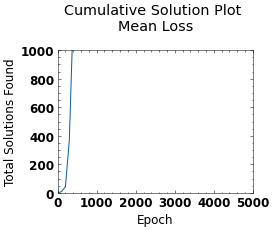

In [ ]:
plt.plot([i*100 for i in range(len(cumulative_solutions))], cumulative_solutions)
plt.ylim(0,1000)
plt.xlim(0,5000)
plt.title("Cumulative Solution Plot \nMean Loss", y = 1.10)
plt.xlabel("Epoch")
plt.ylabel("Total Solutions Found")
plt.savefig("MeanLoss/" + "CumulativeSolution_MeanLoss"+".png")

In [ ]:
#use inside every so many epoch printing          


# figure, axis = plt.subplots(2, 1, figsize=(10,10))
#         plt.figure(figsize=(10, 5))
        
#         if normalize == True:
#             axis[0].plot(normalized_pareto_bstray_numpy, normalized_pareto_kdiff_numpy)
#             axis[0].scatter(x_calc.cpu().data.numpy(), normalized_kdiff_numpy)
#             axis[0].scatter(normalized_bstray_numpy, normalized_kdiff_numpy)
#             axis[0].set_xlim([0,1])
#             axis[0].set_ylim([0,1])
#             axis[0].set_xlabel("Bstray")
#             axis[0].set_ylabel("Kdiff %")
#             axis[0].set_title(f"x_calc vs. designs, epoch: {epoch}")
            
#             axis[1].plot(normalized_pareto_bstray_numpy, normalized_pareto_kdiff_numpy)
#             axis[1].scatter(normalized_bstray_numpy, y_calc.cpu().data.numpy())
#             axis[1].scatter(normalized_bstray_numpy, normalized_kdiff_numpy)
#             axis[1].set_xlim([0,1])
#             axis[1].set_ylim([0,1])
#             axis[1].set_xlabel("Bstray")
#             axis[1].set_ylabel("Kdiff %")
#             axis[1].set_title(f"y_calc vs. designs, epoch: {epoch}")
#         else:
#             axis[0].plot(pareto_bstray_numpy, pareto_kdiff_numpy)
#             axis[0].scatter(x_calc.cpu().data.numpy(), kdiff_numpy)
#             axis[0].scatter(bstray_numpy, kdiff_numpy)
#             axis[0].set_xlim([0,100])
#             axis[0].set_ylim([0,1])
#             axis[0].set_xlabel("Bstray")
#             axis[0].set_ylabel("Kdiff %")
#             axis[0].set_title(f"x_calc vs. designs, epoch: {epoch}")
            
#             axis[1].plot(pareto_bstray_numpy, pareto_kdiff_numpy)
#             axis[1].scatter(bstray_numpy, y_calc.cpu().data.numpy())
#             axis[1].scatter(bstray_numpy, kdiff_numpy)
#             axis[1].set_xlim([0,100])
#             axis[1].set_ylim([0,1])
#             axis[1].set_xlabel("Bstray")
#             axis[1].set_ylabel("Kdiff %")
#             axis[1].set_title(f"y_calc vs. designs, epoch: {epoch}")
            
            
        # plt.xlim([0,100])
        # plt.ylim([0,0.5])
        # plt.show()

0
0


IndexError: ignored

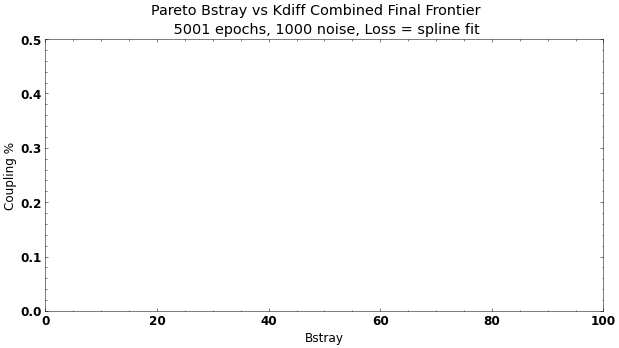

In [ ]:
#scatter plot of final pareto points
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff Combined Final Frontier")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.5])

print(len(pareto_bstray_points2[:]))
print(len(pareto_kdiff_points2[:]))
# print(pareto_bstray_points2[:])
final_x = []
for list in pareto_bstray_points2:
    for item in list:
        final_x.append(item)


final_y = []
for list in pareto_kdiff_points2:
    for item in list:
        final_y.append(item)

final_x, final_y = oldgraph_pareto_frontier(final_x, final_y)
print(len(final_x),len(final_y))

plt.scatter(final_x, final_y)
plt.show() 

In [ ]:
#line plot of final pareto points

plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff Combined Final Frontier")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points2[:]))
print(len(pareto_kdiff_points2[:]))
# print(pareto_bstray_points2[:])
final_x = []
for list in pareto_bstray_points2:
    for item in list:
        final_x.append(item)


final_y = []
for list in pareto_kdiff_points2:
    for item in list:
        final_y.append(item)

final_x, final_y = oldgraph_pareto_frontier(final_x, final_y)
print(len(final_x),len(final_y))

plt.plot(final_x, final_y)
plt.show() 

In [ ]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*50}")
    # plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()


In [ ]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Number of Inverters vs Coilloss During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Num Inverters")
plt.ylabel("Coil loss")
plt.xlim([0,2])
plt.ylim([0, 5000])

print(len(pareto_numinv_points), len(pareto_coilloss_points))

while i < len(pareto_numinv_points):
    plt.plot(pareto_numinv_points[i], pareto_coilloss_points[i], label = f"epoch: {i*50}")
    # plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
# plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

In [ ]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto V_SecCore vs Power Avg During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("V_SecCore")
plt.ylabel("Pave")
plt.xlim([0,3000])
plt.ylim([0, 200])

while i < len(pareto_V_SecCore_points):
    plt.plot(pareto_V_SecCore_points[i], pareto_pave_post_points[i], label = f"epoch: {i*50}")
    # plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
# plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

In [ ]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

In [ ]:
i = 0
print(len(bstray_designs))
#colors = numpy.arange(len(bstray_designs))
colors = numpy.arange(1000)
plt.figure(figsize=(10, 5))
plt.suptitle(f"Bstray vs Kdiff During Training, Generated Designs")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

while i < len(bstray_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    fig = plt.scatter(bstray_designs[i], kdiff_designs[i], label = f"epoch: {i*100}")
    i+=1
    
# plt.colorbar()
plt.legend()
# from matplotlib.patches import Rectangle
# someX, someY = 45, 0.5
# fig,ax = plt.subplots()
# currentAxis = plt.gca()
# currentAxis.add_patch(Rectangle((someX -0.1, someY-0.1), 0.2, 0.2, alpha=0.5, facecolor='red'))
#plt.savefig('Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

In [ ]:
i = 0
fig, ax = plt.subplots()

while i < len(bstray_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    ax.scatter(bstray_designs[i], kdiff_designs[i], label = f"epoch: {i*50}")
    i+=1

plt.xlim(0,200)
plt.ylim(0, 0.2)
plt.legend(title='Training Iteration:')
plt.xlabel("Bstray", fontsize = 18)
plt.ylabel('Coupling %', fontsize = 18)
plt.suptitle(f"Bstray vs Kdiff During Training, \n Generated Designs" , fontsize = 20, y=1.01)
# plt.title(f" {n_epochs} epochs, {n_noise} noise, normalized:{normalize}, Loss = curve fit with {chosen_curve_util.__name__}")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")

rect = patches.Rectangle(( 0,0 ), 45, 0.15, alpha = 0.2, ec = "Crimson", fc = "Red", visible = True)
ax.add_patch(rect)
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(8, 8))
plt.show()

In [ ]:
i = 0
fig, ax = plt.subplots()

while i < len(numinv_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    ax.scatter(numinv_designs[i], coilloss_designs[i], label = f"epoch: {i*50}")
    i+=1

plt.xlim(0,2)
plt.ylim(0, 10000)
plt.legend(title='Training Iteration:')
plt.xlabel("Num Inverters", fontsize = 18)
plt.ylabel('Coil Loss', fontsize = 18)
plt.suptitle(f"Number of Inverters vs Coil Loss During Training, \n Generated Designs" , fontsize = 20, y=1.01)

plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")

rect = patches.Rectangle(( 0,2 ), 1, 2000, alpha = 0.2, ec = "Crimson", fc = "Red", visible = True)
ax.add_patch(rect)
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(8, 8))
plt.show()

In [ ]:
i = 0
fig, ax = plt.subplots()

while i < len(V_SecCore_designs):

    ax.scatter(V_SecCore_designs[i], pave_designs[i], label = f"epoch: {i*50}")
    i+=1

plt.xlim(0,5000)
plt.ylim(0, 200)
plt.legend(title='Training Iteration:')
plt.xlabel("V_SecCore", fontsize = 18)
plt.ylabel('Pave', fontsize = 18)
plt.suptitle(f"V_SecCore vs Power Average During Training \n Generated Designs" , fontsize = 20, y=1.01)

plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = spline fit")

rect = patches.Rectangle((0,30), 1500, 200, alpha = 0.2, ec = "Crimson", fc = "Red", visible = True)
ax.add_patch(rect)
plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(8, 8))
plt.show()

In [ ]:
noise = generate_noise(shape=(10_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

pareto_bstray, pareto_kdiff = pareto_frontier(bstray, kdiff)
pareto_kdiff = pareto_kdiff * 100

plt.plot(pareto_bstray.detach().cpu(), pareto_kdiff.detach().cpu())

In [ ]:
noise = generate_noise(shape=(25_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

plt.scatter(bstray.detach().cpu(), kdiff.detach().cpu())
plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Bstray")
plt.ylabel("Kdiff")
plt.show()

In [ ]:
noise = generate_noise(shape=(3, 10))
gp = gp_model(noise)

noise = noise.cpu().numpy()
gp = gp.cpu().detach().numpy()

for i in range(3):
    print(f"Noise {i}")
    print(noise[i])
    print()
    print(f"Generated Parameters {i}")
    print(gp[i])
    print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.title(f"KDiff Error During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

plt.plot(numpy.arange(len(kdiffs)), kdiffs)
plt.show()


plt.figure(figsize=(10, 5))
plt.title(f"BStray Error During Training")
plt.xlabel("Epoch")
plt.ylabel("BStray")

plt.plot(numpy.arange(len(bstrays)), bstrays)
plt.show()

In [ ]:
accepted_solutions[0] = 0
max_value = max(accepted_solutions)
max_index = accepted_solutions.index(max_value)

plt.plot([ i*10 for i in range(len(accepted_solutions))], accepted_solutions)
# plt.plot(epoch, accepted_solutions)

# # plt.scatter(mark, marked_points, marker='o',color='y')
# plt.scatter([max_index], [max_value], marker = 'o', color = 'r')

# plt.annotate('Max number of solutions ('+ str(max_value)+') at epoch '+str(max_index), xy=(max_index,max_value), xycoords='data',
#             xytext=(-90,60), textcoords='offset points',
#             arrowprops=dict(arrowstyle='fancy',fc='0.2',
#                             connectionstyle="angle3,angleA=45,angleB=90"))
plt.xlabel("Number of epochs")
plt.ylabel("Accepted solutions out of 1000")
plt.title("Random Generation")
plt.savefig("RandomGeneration/" + "soultions_per_epoch.png")
plt.show()
plt.clf()